In [1]:
!pip install transformers
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
import numpy as np
import pandas as pd
import seaborn as sns
# from pylab import rcParams
import matplotlib.pyplot as plt
# from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
# from textwrap import wrap
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

     |████████████████████████████████| 2.6 MB 7.8 MB/s 
     |████████████████████████████████| 636 kB 56.8 MB/s 
     |████████████████████████████████| 895 kB 70.0 MB/s 
     |████████████████████████████████| 3.3 MB 53.2 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
# %matplotlib inline
# %config InlineBackend.figure_format='retina'
# sns.set(style='whitegrid', palette='muted', font_scale=1.2)
# HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
# sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
# rcParams['figure.figsize'] = 12, 8
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
path="drive/MyDrive/bert/"

In [4]:
# !pip install -q -U watermark
# !pip install -qq transformers
# %reload_ext watermark
# %watermark -v -p numpy,pandas,torch,transformers

In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
import numpy as np
import pandas as pd
df=pd.read_csv(path+'Train.csv')
df.drop('Unnamed: 0',axis=1,inplace=True)

In [7]:
df

,tweet_id,airline_sentiment,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,569612379811676161,negative,US Airways,NaN,09202010,NaN,0,@USAirways US Airlines 699 LA to RDU is holdin...,NaN,2015-02-22 13:39:08 -0800,NaN,Mountain Time (US & Canada)
1,570283248301043712,negative,Southwest,NaN,slobotski,NaN,0,@SouthwestAir went to purchase a flight that I...,NaN,2015-02-24 10:04:56 -0800,Midwest + Airplanes,Central Time (US & Canada)
2,569684565838553088,negative,American,NaN,61jr,NaN,0,@AmericanAir their flights into Buffalo as wel...,NaN,2015-02-22 18:25:59 -0800,St. Catharines,NaN
3,569313126342123520,negative,US Airways,NaN,iZoom23,NaN,0,@USAirways Sitting in a cesspool of germs on t...,NaN,2015-02-21 17:50:01 -0800,New York,Eastern Time (US & Canada)
4,569723892358467584,negative,United,NaN,ljtypes,NaN,0,@united you advertise the flight and its still...,NaN,2015-02-22 21:02:15 -0800,H-town,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
7681,569599532268449792,negative,US Airways,NaN,jadedhippie09,NaN,0,"@USAirways I promise, if I can help it I will ...",NaN,2015-02-22 12:48:05 -0800,NaN,NaN
7682,568475947617411072,neutral,US Airways,NaN,Darren_howudoin,NaN,0,"“@USAirways: Reminder: From 2/28, we’ll be twe...",NaN,2015-02-19 10:23:22 -0800,North Carolina/LosAngeles,Eastern Time (US & Canada)
7683,569392511732588544,negative,US Airways,NaN,emmaprzyby,NaN,0,@USAirways flight 1898 landed over 2 hours ago...,NaN,2015-02-21 23:05:28 -0800,"Brooklyn, NY",NaN
7684,568675083314552832,positive,United,NaN,Kimberlinho,NaN,0,@united alright thank you. Much appreciated.,NaN,2015-02-19 23:34:39 -0800,NaN,NaN


In [8]:
df.isnull().sum()

tweet_id                     0
airline_sentiment            0
airline                      0
airline_sentiment_gold    7666
name                         0
negativereason_gold       7670
retweet_count                0
text                         0
tweet_coord               7140
tweet_created                0
tweet_location            2469
user_timezone             2538
dtype: int64

In [9]:
dft=pd.read_csv(path+'Test.csv')
dft.drop('Unnamed: 0',axis=1,inplace=True)
df = df.drop(['tweet_id', 'tweet_coord', 'tweet_created',
                               'tweet_location','name','user_timezone','airline_sentiment_gold','negativereason_gold'],axis = 1)#retweet_count
dft = dft.drop(['tweet_id', 'tweet_coord', 'tweet_created',
                               'tweet_location','name','user_timezone','airline_sentiment_gold','negativereason_gold'],axis = 1)

In [10]:
from sklearn.preprocessing import LabelEncoder
le=LabelEncoder()
df['sentiment']=le.fit_transform(df['airline_sentiment'])

In [11]:
dft['sentiment']=0
dft['airline_sentiment']=''

In [12]:
dft

,airline,retweet_count,text,sentiment,airline_sentiment
0,Southwest,0,"@SouthwestAir I am scheduled for the morning, ...",0,
1,Delta,0,@JetBlue that is a stock response. Delays not ...,0,
2,Delta,0,@JetBlue That'd be nice! Hoping to rack up eno...,0,
3,Southwest,0,@SouthwestAir yeah haha. Never been in one. It...,0,
4,Delta,0,@JetBlue what's the easiest way to get a ticke...,0,
...,...,...,...,...,...
3289,Southwest,0,@SouthwestAir go south everyone,0,
3290,United,1,@united 3 times my flight has been delayed and...,0,
3291,Delta,0,"@JetBlue there is no supervisor available, so ...",0,
3292,US Airways,0,@USAirways even alternate options are allready...,0,


In [13]:
class_names = ['negative', 'neutral', 'positive']

In [14]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'

In [15]:
tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL_NAME)

In [16]:
sample_txt = 'When was I last outside? I am stuck at home for 2 weeks.'

In [17]:
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)
print(f' Sentence: {sample_txt}')
print(f'   Tokens: {tokens}')
print(f'Token IDs: {token_ids}')

 Sentence: When was I last outside? I am stuck at home for 2 weeks.
   Tokens: ['When', 'was', 'I', 'last', 'outside', '?', 'I', 'am', 'stuck', 'at', 'home', 'for', '2', 'weeks', '.']
Token IDs: [1332, 1108, 146, 1314, 1796, 136, 146, 1821, 5342, 1120, 1313, 1111, 123, 2277, 119]


In [18]:
encoding = tokenizer.encode_plus(
  sample_txt,
  max_length=32,
  add_special_tokens=True, # Add '[CLS]' and '[SEP]'
  return_token_type_ids=False,
  padding='max_length',
  return_attention_mask=True,
  return_tensors='pt',  # Return PyTorch tensors
)
encoding.keys()

dict_keys(['input_ids', 'attention_mask'])

In [19]:
print(len(encoding['input_ids'][0]))
encoding['input_ids'][0]

32


tensor([ 101, 1332, 1108,  146, 1314, 1796,  136,  146, 1821, 5342, 1120, 1313,
        1111,  123, 2277,  119,  102,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0])

In [20]:
print(len(encoding['attention_mask'][0]))
encoding['attention_mask']

32


tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0]])

In [21]:
tokenizer.convert_ids_to_tokens(encoding['input_ids'][0])

['[CLS]',
 'When',
 'was',
 'I',
 'last',
 'outside',
 '?',
 'I',
 'am',
 'stuck',
 'at',
 'home',
 'for',
 '2',
 'weeks',
 '.',
 '[SEP]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]',
 '[PAD]']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Token count')

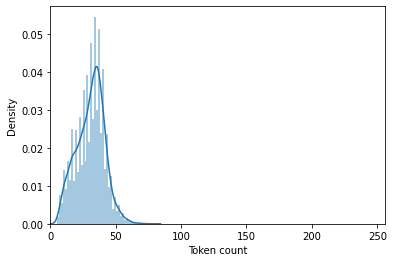

In [22]:
token_lens = []
for txt in df.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

In [23]:
max(token_lens)

79

In [24]:
MAX_LEN = 85

In [25]:
class SentimentAnalysisis(Dataset):
  def __init__(self, reviews, targets, tokenizer, max_len):
    self.reviews = reviews
    self.targets = targets
    self.tokenizer = tokenizer
    self.max_len = max_len
  def __len__(self):
    return len(self.reviews)
  def __getitem__(self, item):
    review = str(self.reviews[item])
    target =  self.targets[item]
    encoding = self.tokenizer.encode_plus(
      review,
      add_special_tokens=True,
      max_length=self.max_len,
      return_token_type_ids=False,
      padding='max_length',
      return_attention_mask=True,
      return_tensors='pt',
    )
    return {
      'review_text': review,
      'input_ids': encoding['input_ids'].flatten(),
      'attention_mask': encoding['attention_mask'].flatten(),
      'targets': torch.tensor(target, dtype=torch.long)
    }

In [26]:
df_train, df_test = train_test_split(df, test_size=0.05, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.03, random_state=RANDOM_SEED)

In [27]:
df_train.shape, df_val.shape, df_test.shape

((7301, 5), (373, 5), (12, 5))

In [28]:
df.sentiment.to_numpy()

array([0, 0, 0, ..., 0, 2, 0])

In [29]:
def create_data_loader(df, tokenizer, max_len, batch_size):
  ds = SentimentAnalysis(
    reviews=df.text.to_numpy(),
    targets=df.sentiment.to_numpy(),
    tokenizer=tokenizer,
    max_len=max_len
  )

  return DataLoader(
    ds,
    batch_size=batch_size,
    num_workers=4
  )

In [30]:
BATCH_SIZE = 16

train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [31]:
finalTest_DL=create_data_loader(dft, tokenizer, MAX_LEN, BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [32]:
dft


,airline,retweet_count,text,sentiment,airline_sentiment
0,Southwest,0,"@SouthwestAir I am scheduled for the morning, ...",0,
1,Delta,0,@JetBlue that is a stock response. Delays not ...,0,
2,Delta,0,@JetBlue That'd be nice! Hoping to rack up eno...,0,
3,Southwest,0,@SouthwestAir yeah haha. Never been in one. It...,0,
4,Delta,0,@JetBlue what's the easiest way to get a ticke...,0,
...,...,...,...,...,...
3289,Southwest,0,@SouthwestAir go south everyone,0,
3290,United,1,@united 3 times my flight has been delayed and...,0,
3291,Delta,0,"@JetBlue there is no supervisor available, so ...",0,
3292,US Airways,0,@USAirways even alternate options are allready...,0,


In [33]:
 df_test

,airline_sentiment,airline,retweet_count,text,sentiment
7347,negative,United,0,"@united yes, I know that. The question is ""why...",0
4684,positive,Southwest,0,"@SouthwestAir have to be honest, didn't expect...",2
239,negative,American,0,@AmericanAir I am looking for help on USAirway...,0
4228,neutral,United,0,"@united Alright, thank you. Is there a page th...",1
3113,negative,Southwest,0,@SouthwestAir is really gonna hear my mouth ab...,0
6681,negative,US Airways,0,@USAirways too Late Flight.,0
4477,neutral,US Airways,0,@USAirways in a few weeks,1
6343,neutral,Southwest,0,@SouthwestAir arrangements to reimburse me for...,1
6969,neutral,United,0,@united A Tourist Wonder: Super Tides and Tide...,1
2549,neutral,United,0,@united I'm a UA 1k. I think it's @iamtedking ...,1


In [34]:
data = next(iter(train_data_loader))
data.keys()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])

In [35]:
print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

torch.Size([16, 85])
torch.Size([16, 85])
torch.Size([16])


In [36]:
bert_model = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [37]:
last_hidden_state, pooled_output = bert_model(
  input_ids=encoding['input_ids'], 
  attention_mask=encoding['attention_mask']
)

In [38]:
# last_hidden_state.shape

In [39]:
bert_model.config.hidden_size

768

In [40]:
# pooled_output.shape

In [41]:
class SentimentClassifier(nn.Module):

  def __init__(self, n_classes):
    super(SentimentClassifier, self).__init__()
    self.bert = BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)
    self.drop = nn.Dropout(p=0.3)
    self.out = nn.Linear(self.bert.config.hidden_size, n_classes)
  
  def forward(self, input_ids, attention_mask):
    output = self.bert(
        input_ids = input_ids,
        attention_mask = attention_mask
    ) 
    pooled_output = output[1]
    output = self.drop(pooled_output)
    return self.out(output)

In [42]:
model = SentimentClassifier(len(class_names))
model = model.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [43]:
input_ids = data['input_ids'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 85])
torch.Size([16, 85])


In [44]:
import torch.nn.functional as F

In [45]:
F.softmax(model(input_ids, attention_mask), dim=1)

tensor([[0.2169, 0.4549, 0.3282],
        [0.2398, 0.3291, 0.4311],
        [0.3423, 0.2614, 0.3964],
        [0.2051, 0.4148, 0.3801],
        [0.5983, 0.1924, 0.2092],
        [0.2120, 0.4595, 0.3285],
        [0.2775, 0.3278, 0.3947],
        [0.3752, 0.2341, 0.3907],
        [0.3938, 0.1731, 0.4330],
        [0.3116, 0.2010, 0.4874],
        [0.3309, 0.2654, 0.4037],
        [0.3612, 0.2110, 0.4278],
        [0.2214, 0.3965, 0.3821],
        [0.2601, 0.3263, 0.4136],
        [0.3247, 0.2542, 0.4210],
        [0.1448, 0.3821, 0.4731]], device='cuda:0', grad_fn=<SoftmaxBackward>)

In [46]:
EPOCHS = 5

optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_steps
)

loss_fn = nn.CrossEntropyLoss().to(device)

In [47]:
def train_epoch(
  model, 
  data_loader, 
  loss_fn, 
  optimizer, 
  device, 
  scheduler, 
  n_examples
):
  model = model.train()

  losses = []
  correct_predictions = 0
  
  for d in data_loader:
    input_ids = d["input_ids"].to(device)
    attention_mask = d["attention_mask"].to(device)
    targets = d["targets"].to(device)

    outputs = model(
      input_ids=input_ids,
      attention_mask=attention_mask
    )

    _, preds = torch.max(outputs, dim=1)
    loss = loss_fn(outputs, targets)

    correct_predictions += torch.sum(preds == targets)
    losses.append(loss.item())

    loss.backward()
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()
    scheduler.step()
    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [48]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  model = model.eval()

  losses = []
  correct_predictions = 0

  with torch.no_grad():
    for d in data_loader:
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      loss = loss_fn(outputs, targets)

      correct_predictions += torch.sum(preds == targets)
      losses.append(loss.item())

  return correct_predictions.double() / n_examples, np.mean(losses)

In [49]:
# from collections import defaultdict

In [50]:
path="drive/MyDrive/bert/"

In [51]:
%%time

history = {'train_acc':[],'val_acc':[],'train_loss':[],'val_loss':[]}
best_accuracy = 0

for epoch in range(EPOCHS):

  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,    
    loss_fn, 
    optimizer, 
    device, 
    scheduler, 
    len(df_train)
  )

  print(f'Train loss {train_loss} accuracy {train_acc}')

  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn, 
    device, 
    len(df_val)
  )

  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()

  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), path+'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/5
----------


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Train loss 0.5385555899182347 accuracy 0.7878372825640323
Val   loss 0.3974084009726842 accuracy 0.8525469168900804

Epoch 2/5
----------
Train loss 0.270963682488414 accuracy 0.9076838789206958
Val   loss 0.5396245174730817 accuracy 0.8445040214477212

Epoch 3/5
----------
Train loss 0.13733954826806502 accuracy 0.959731543624161
Val   loss 0.7456459837655226 accuracy 0.8418230563002681

Epoch 4/5
----------
Train loss 0.08321203800395673 accuracy 0.9797288042733872
Val   loss 0.7770477356389165 accuracy 0.8418230563002681

Epoch 5/5
----------
Train loss 0.05107607344813498 accuracy 0.987535953978907
Val   loss 0.8153340083857378 accuracy 0.8418230563002681

CPU times: user 9min 41s, sys: 39.8 s, total: 10min 21s
Wall time: 10min 30s


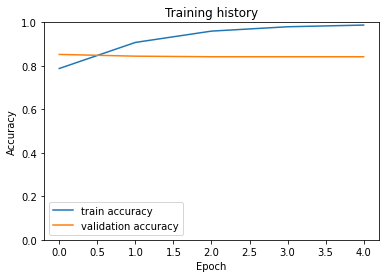

In [52]:
plt.plot(history['train_acc'], label='train accuracy')
plt.plot(history['val_acc'], label='validation accuracy')

plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

In [53]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0.9166666666666666

In [54]:
def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_text"]
      input_ids = d["input_ids"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["targets"].to(device)

      outputs = model(
        input_ids=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = F.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [59]:
y_review_texts, y_pred, y_pred_probs,y_test = get_predictions(
  model,
  test_data_loader
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [60]:
# import os
# path=os.getcwd()+"/drive/MyDrive/bert/"
# torch.save(model.state_dict(), path+'best_model_state.bin')

In [61]:
print(classification_report(y_test, y_pred, target_names=class_names))

              precision    recall  f1-score   support

    negative       0.83      1.00      0.91         5
     neutral       1.00      0.80      0.89         5
    positive       1.00      1.00      1.00         2

    accuracy                           0.92        12
   macro avg       0.94      0.93      0.93        12
weighted avg       0.93      0.92      0.92        12



In [62]:
y_review_textsf, y_predf, y_pred_probsf, y_testf = get_predictions(
  model,
  finalTest_DL 
)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [63]:
y_predf.shape[0]

3294

In [64]:
Predicted=[]

In [65]:
for i in range(y_predf.shape[0]):
               if(y_predf[i]==0):
                 Predicted+=['negative']
               elif(y_predf[i]==1):
                 Predicted+=['neutral']
               elif(y_predf[i]==2):
                 Predicted+=['positive']

In [66]:
len(Predicted)

3294

In [67]:
dff=pd.DataFrame(np.array(Predicted),columns=['Predicted'])

In [68]:
dff.index.name='Id'

In [69]:
dff.to_csv(path+'Predictions.csv')